# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, Normalizer, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.4.0-x86_64-i386-64bit
NumPy 1.14.2
SciPy 1.0.1
Scikit-Learn 0.19.1


### paths configuration

In [3]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [4]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [5]:
problems = readCollectionsOfProblems(inputDir);

In [6]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [7]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [8]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [9]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [11]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [12]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [13]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

<br/><br/><br/><br/><br/>

#  Abordagem desafiante 1

In [15]:
from sklearn.metrics import pairwise_distances;

In [16]:
class DistanceTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self,
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True,
                distance='cosine'):

            self.analyzer=analyzer;
            self.min_df=min_df;
            self.max_df=max_df;
            self.ngram_range=ngram_range;
            self.lowercase=lowercase;
            self.norm=norm;
            self.sublinear_tf=sublinear_tf
            self.distance = distance;
            

    def fit(self, X, y):
        self.vectorizer_ = TfidfVectorizer(
                analyzer=self.analyzer,
                min_df=self.min_df,
                max_df=self.max_df,
                ngram_range=self.ngram_range,
                lowercase=self.lowercase,
                norm=self.norm,
                sublinear_tf=self.sublinear_tf);
        
        #building the internal vocabulary
        self.vectorizer_.fit(X);
        
        #creating author profile
        profile = defaultdict(unicode);
        for text, label in zip(train_docs,train_labels):
            profile[label]+=text;
        
        #make sure the labels are going to be sorted
        self.profileLabels_ = set(profile.keys());
        x = [ profile[label] for label in self.profileLabels_]
            
        self.profileVector_ = self.vectorizer_.transform(x);
        
        return self;

    def transform(self, X, y=None):
        X = self.vectorizer_.transform(X);
        XD = pairwise_distances(X.todense(), self.profileVector_.todense(), metric = self.distance);
        return XD;

    def fit_transform(self, X, y):
        self.fit(X,y);
        return self.transform(X=X, y=y)

In [28]:
class DTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self,
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True,
                distances=['cosine']):

            self.analyzer=analyzer;
            self.min_df=min_df;
            self.max_df=max_df;
            self.ngram_range=ngram_range;
            self.lowercase=lowercase;
            self.norm=norm;
            self.sublinear_tf=sublinear_tf
            self.distances = distances;
            

    def fit(self, X, y):
        self.vectorizer_ = TfidfVectorizer(
                analyzer=self.analyzer,
                min_df=self.min_df,
                max_df=self.max_df,
                ngram_range=self.ngram_range,
                lowercase=self.lowercase,
                norm=self.norm,
                sublinear_tf=self.sublinear_tf);
        
        #building the internal vocabulary
        self.vectorizer_.fit(X);
        
        #creating author profile
        profile = defaultdict(unicode);
        for text, label in zip(train_docs,train_labels):
            profile[label]+=text;
        
        #make sure the labels are going to be sorted
        self.profileLabels_ = set(profile.keys());
        x = [ profile[label] for label in self.profileLabels_]
            
        self.profileVector_ = self.vectorizer_.transform(x);
        
        return self;

    def transform(self, X, y=None):
        X = self.vectorizer_.transform(X);
        XD = [
            pairwise_distances(X.todense(), self.profileVector_.todense(), metric = d)
             for d in self.distances];
        XD = np.hstack(XD);
        return XD;

    def fit_transform(self, X, y):
        self.fit(X,y);
        return self.transform(X=X, y=y)

In [29]:
distancesList =['cosine',  'l1', 'l2',  'braycurtis', 'canberra',  'hamming', 'jaccard','rogerstanimoto','yule']

In [46]:
problem = problems[2];
print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))

Problem: problem00003,  language: fr, 


In [47]:
train_docs, train_labels,_ = zip(*problem['candidates']);

In [48]:
#code from baseline
gt = {}
with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

In [49]:
test_docs, _, test_filename = zip(*problem['unknown'])
test_labels = [gt[v] for v in test_filename]

In [51]:
results = [];
vect = DTransformer(distances=distancesList)
vect.fit(train_docs, train_labels);
trainx = vect.transform(train_docs);
testx  = vect.transform(test_docs);
clf = LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')
clf.fit(trainx,train_labels);
test_pred =clf.predict(testx);
f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, test_pred)  })
results.append({ 'caso' :'',
                'problem-name'   : problem['problem'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3)
             })

In [52]:
pd.DataFrame(results).sort_values('macro-f1',ascending=False)

,caso,macro-f1,macro-precision,macro-recall,micro-accuracy,problem-name
0,,0.672,0.662,0.737,0.714,problem00003


In [40]:
trainx.shape

(140, 180)

In [37]:
t=1-np.exp(trainx)/np.exp(trainx).sum(axis=1,keepdims=True)

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


In [ ]:
metrics.pairwise_distances_argmin_min(X, Y)

In [42]:
def runML(problem):
    print ("\n\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    train_docs, train_labels,_ = zip(*problem['candidates']);
    #code from baseline
    gt = {}
    with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']
            
    test_docs, _, test_filename = zip(*problem['unknown'])
    test_labels = [gt[v] for v in test_filename]
    
    
    results = [];

    vect = DistanceTransformer(min_df=0.1);
    vect.fit(train_docs,train_labels);
    
    

    clf = Pipeline([
        ('normalizer', Normalizer()),
        ('scaler',MaxAbsScaler()),
        ('clf', LogisticRegression(random_state=0))
    ])

    for distance in distancesList:
        print(distance)
        vect.distance = distance;
        trainx = vect.transform(train_docs);
        testx  = vect.transform(test_docs);

        clf.fit(trainx,train_labels);
        test_pred =clf.predict(testx);
        f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, test_pred)  })
        results.append({ 'caso' :distance,
                        'problem-name'   : problem['problem'],
                        'macro-f1'       : round(f1,3),
                        'macro-precision': round(precision,3),
                        'macro-recall'   : round(recall,3),
                        'micro-accuracy' : round(accuracy,3)
                     })
    return results;

In [43]:
results =[t
    for problem in problems for t in runML(problem)];




Problem: problem00001,  language: en, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00002,  language: en, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00003,  language: fr, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00004,  language: fr, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00005,  language: it, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00006,  language: it, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00007,  language: pl, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00008,  language: pl, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00009,  language: sp, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem:

In [44]:
df= pd.DataFrame(results)

In [45]:
import seaborn as sns

df2= df[['macro-f1','caso','problem-name']].pivot(index='problem-name', columns='caso', values='macro-f1').reset_index()
cm = sns.light_palette("green", as_cmap=True)
df2=df2.style.background_gradient(cmap=cm,axis=1)
df2

caso,problem-name,braycurtis,canberra,cosine,hamming,jaccard,l1,l2,rogerstanimoto,yule
0,problem00001,0.381,0.258,0.41,0.244,0.229,0.394,0.395,0.226,0.316
1,problem00002,0.49,0.49,0.467,0.528,0.564,0.49,0.467,0.564,0.509
2,problem00003,0.134,0.121,0.078,0.117,0.067,0.134,0.078,0.143,0.092
3,problem00004,0.295,0.365,0.271,0.336,0.261,0.295,0.271,0.333,0.252
4,problem00005,0.069,0.046,0.029,0.027,0.059,0.036,0.029,0.05,0.055
5,problem00006,0.25,0.274,0.249,0.252,0.23,0.245,0.249,0.278,0.265
6,problem00007,0.093,0.062,0.123,0.031,0.033,0.093,0.119,0.046,0.032
7,problem00008,0.27,0.254,0.14,0.474,0.33,0.27,0.14,0.457,0.299
8,problem00009,0.109,0.134,0.123,0.12,0.097,0.132,0.119,0.112,0.09
9,problem00010,0.163,0.213,0.1,0.258,0.185,0.141,0.1,0.183,0.2


In [ ]:
import seaborn as sns

df2= df[['macro-f1','caso','problem-name']].pivot(index='problem-name', columns='caso', values='macro-f1').reset_index()
cm = sns.light_palette("green", as_cmap=True)
df2=df2.style.background_gradient(cmap=cm,axis=1)
df2

In [ ]:
r = np.exp(np.random.rand(2000)*5)

In [ ]:
plt.hist(r, bins=50);

In [ ]:
gamma =0.001
t = (r**gamma-1)/gamma
plt.hist(t,bins=30);

In [ ]:
plt.scatter(x=t,y=r)

In [ ]:
np.hstack(([[1,2],[3,4]],[[5,6],[7,8]]))

In [93]:
d = vect.vectorizer_.transform(test_docs)

In [122]:
from sklearn.metrics.pairwise import chi2_kernel, sigmoid_kernel, cosine_distances, rbf_kernel , laplacian_kernel

In [126]:
s = cosine_distances(d.todense(),vect.profileVector_.todense())
r = s.argmin(axis=1)

In [127]:
1.0*np.sum([list(vect.profileLabels_)[rr] for rr in r] == np.array(test_labels))/len(test_labels)

0.7142857142857143

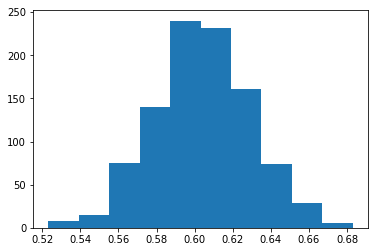

In [133]:
plt.hist(s.flatten());